In [19]:
import sys
print(sys.version)
print(sys.executable)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
C:\Users\87252\anaconda3\envs\FGSM\python.exe


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

75.7%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw




100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [7]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [8]:
torch.cuda. is_available()

True

In [9]:
# ATTACK
# Attack on LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) # padding added to match input size requirements
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120) # Adjusted for the MNIST dataset size after convolutions and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # Output layer for 10 classes

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # First conv layer + pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # Second conv layer + pooling
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) # Using log_softmax for compatibility with NLLLoss

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [10]:
model = LeNet().to(device)

In [11]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [12]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [13]:
loss,val_loss=fit(model,device,train_loader,val_loader,5) # 10 is better but too long time

Fitting the model...
Epoch: 1 Loss: 0.24397713338934252 Val_Loss: 0.0978328358164754
Epoch: 2 Loss: 0.078651230282576 Val_Loss: 0.07339950804879526
Epoch: 3 Loss: 0.05540914655909286 Val_Loss: 0.05206776890209891
Epoch: 4 Loss: 0.043009046514428294 Val_Loss: 0.05083337245575506
Epoch: 5 Loss: 0.03484802210672885 Val_Loss: 0.05174107253538674


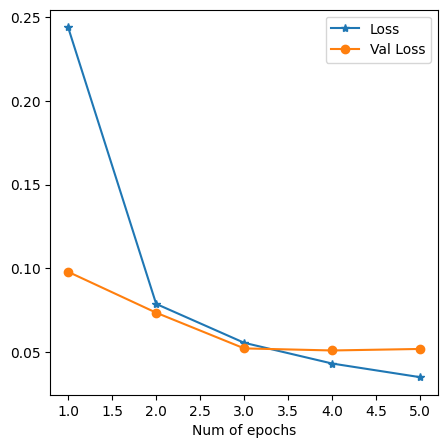

In [14]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,6), loss, "*-",label="Loss")
plt.plot(np.arange(1,6), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [15]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [16]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9880 / 10000 = 0.988
Epsilon: 0.05	Test Accuracy = 9277 / 10000 = 0.9277
Epsilon: 0.1	Test Accuracy = 7623 / 10000 = 0.7623
Epsilon: 0.2	Test Accuracy = 2406 / 10000 = 0.2406
Epsilon: 0.3	Test Accuracy = 292 / 10000 = 0.0292


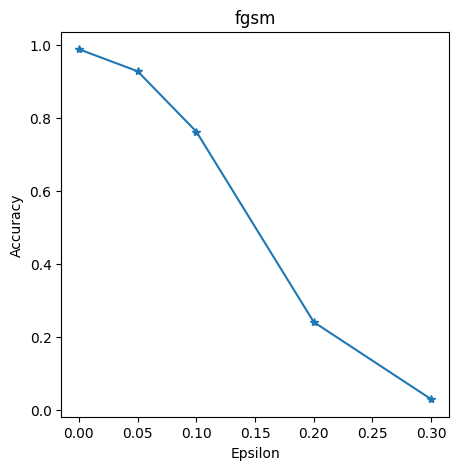

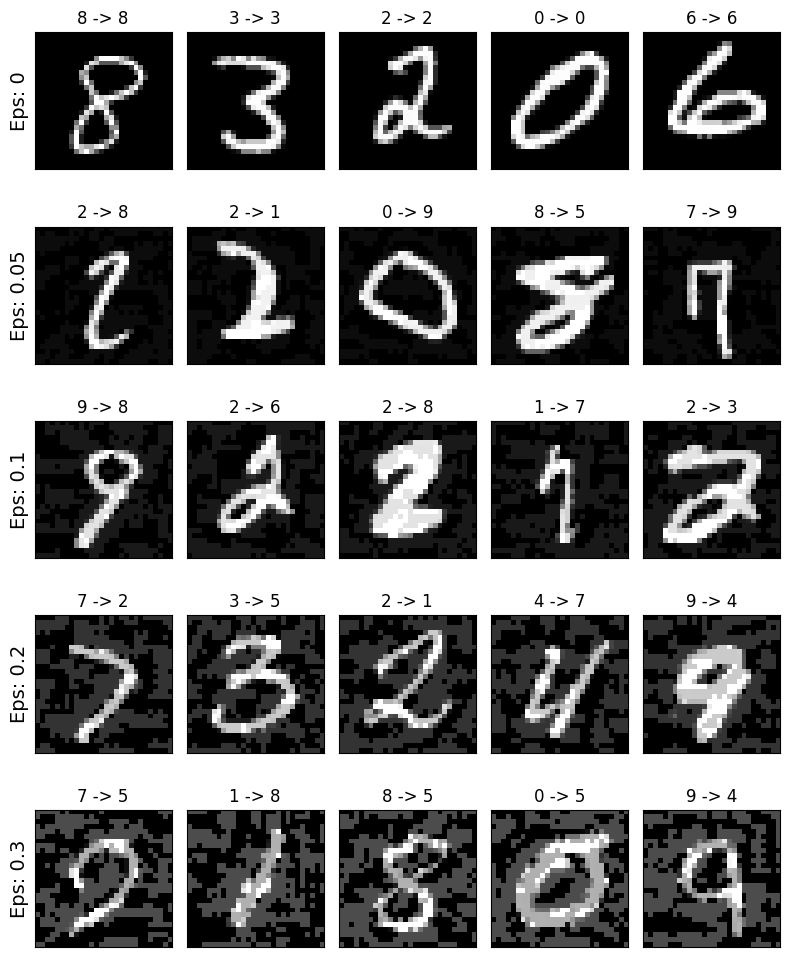

Epsilon: 0	Test Accuracy = 9880 / 10000 = 0.988
Epsilon: 0.05	Test Accuracy = 9368 / 10000 = 0.9368
Epsilon: 0.1	Test Accuracy = 8072 / 10000 = 0.8072
Epsilon: 0.2	Test Accuracy = 3325 / 10000 = 0.3325
Epsilon: 0.3	Test Accuracy = 598 / 10000 = 0.0598


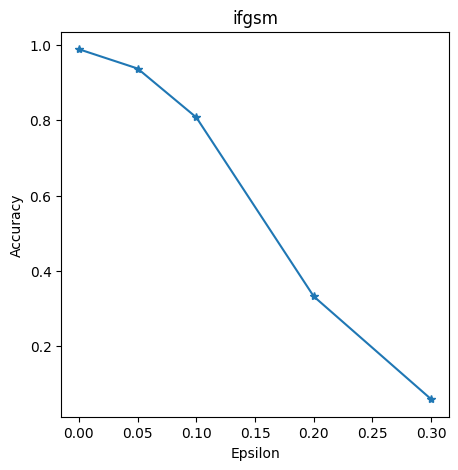

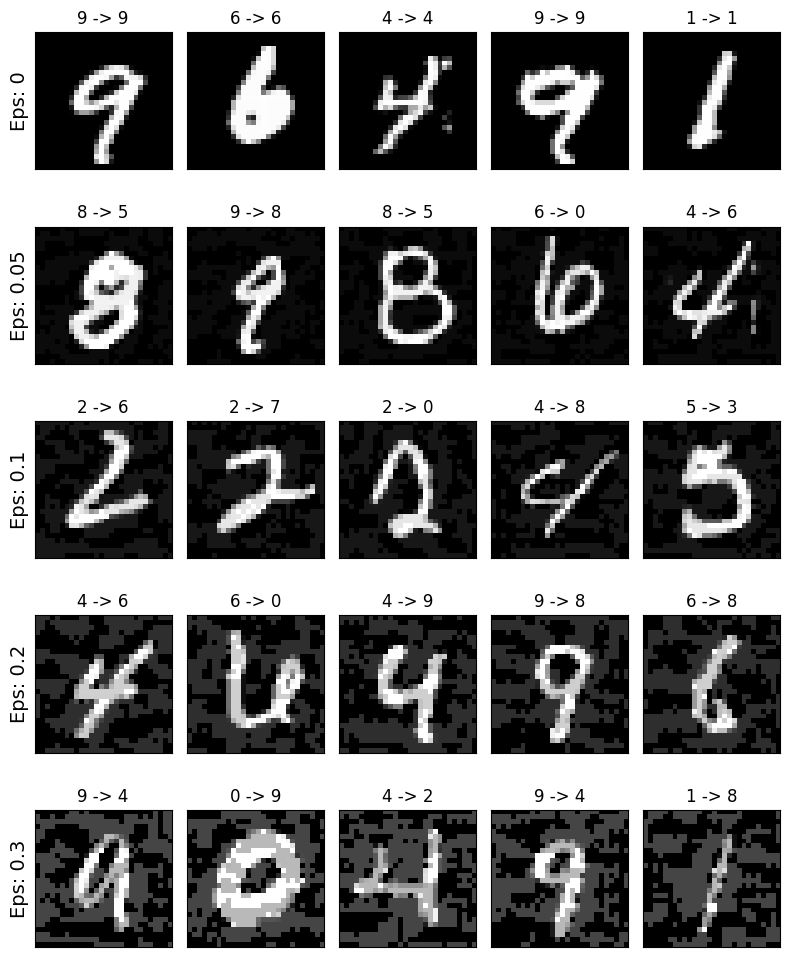

Epsilon: 0	Test Accuracy = 9880 / 10000 = 0.988
Epsilon: 0.05	Test Accuracy = 9368 / 10000 = 0.9368
Epsilon: 0.1	Test Accuracy = 8072 / 10000 = 0.8072
Epsilon: 0.2	Test Accuracy = 3325 / 10000 = 0.3325
Epsilon: 0.3	Test Accuracy = 598 / 10000 = 0.0598


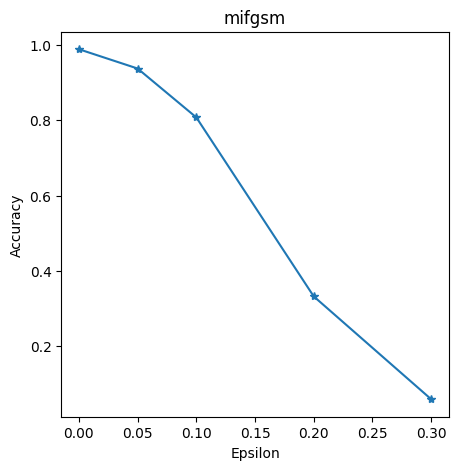

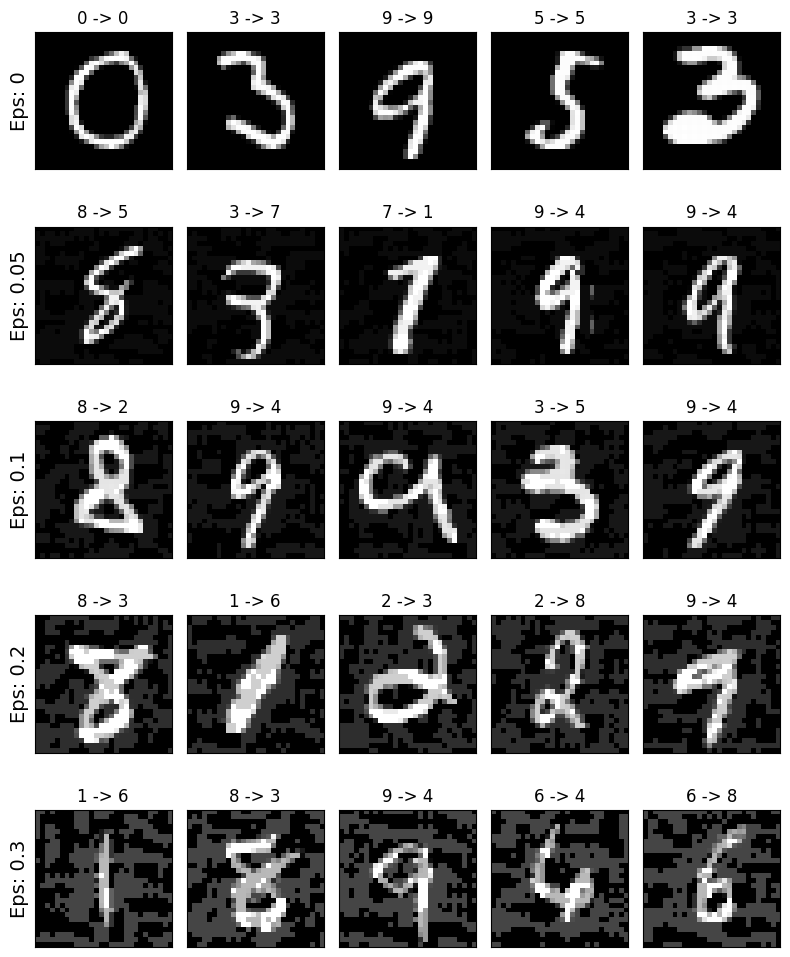

In [17]:
#epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
epsilons = [0,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def test_and_evaluate(model, device, test_loader, epsilon, attack):
    correct = 0
    all_preds = []
    all_targets = []
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            continue
        
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        if attack == "fgsm":
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data, epsilon, data_grad)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data, epsilon, data_grad)
        
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        
        all_targets.extend(target.view_as(final_pred).cpu().numpy())
        all_preds.extend(final_pred.cpu().numpy())
        
        if final_pred.item() == target.item():
            correct += 1
            
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    
    return all_targets, all_preds

# Choose an epsilon value to generate report for
epsilon = 0.3  # Example epsilon
attack = "fgsm"  # Example attack
targets, preds = test_and_evaluate(model, device, test_loader, epsilon, attack)

# Generate confusion matrix
conf_matrix = confusion_matrix(targets, preds)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(targets, preds)
print("Classification Report:\n", class_report)


Epsilon: 0.3	Test Accuracy = 292 / 10000 = 0.0292
Confusion Matrix:
 [[ 57   2 128  31   2 233 359  13  50 100]
 [  0   2 110  10  62   7 313  24 599   0]
 [ 19 108  17 613   7  54  24  73  95   5]
 [  5  14  41  47   2 644   3  32 150  64]
 [  1   7  34  49   4  31 204  15 320 307]
 [  6   0  14 352   2  30 124   2 275  77]
 [161  14  22  76  21 481  81   2  75  19]
 [  1 111 172 430  26  40   4  30  96 104]
 [  9  21 125 339  19 265  61  36  20  61]
 [  4   4  22  26 537  81  32  83 192   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.06      0.09       975
           1       0.01      0.00      0.00      1127
           2       0.02      0.02      0.02      1015
           3       0.02      0.05      0.03      1002
           4       0.01      0.00      0.00       972
           5       0.02      0.03      0.02       882
           6       0.07      0.09      0.08       952
           7       0.10      0.03      0.05